In [56]:
using LinearAlgebra
using SpecialFunctions
using Random
using ForwardDiff
using MultiQuad
using Plots

include("../src/Misc.jl");
include("../src/GreensFunction.jl");
include("../src/InteractionMatrix.jl");
include("../src/Fields.jl");
include("../src/ComplexGradient.jl")
include("../src/Power.jl")

Gintegral (generic function with 3 methods)

In [57]:
ω = 1.
J = Stdd(1.);

scattpos = [[1. 2. 3.]
            [2. 3. 4.]];

alphas = [(1. + 2im)
          (1. - 2im)];

ϕinput = [(1. +1im), (2. +1im)];

x = [1., 1., 0.];

In [78]:
Gintegral(2, ω, J)

LoadError: InterruptException:

### Gradient test

In [3]:
xx = LinRange(0, 10, 20)
f(x) = sin(x[1]) + cos(x[2])
g(x) = ForwardDiff.gradient(f, x)

g (generic function with 1 method)

In [13]:
yy = zeros(20)
yy2 = zeros(20)

for i in 1:20
    yy[i] = f([0, xx[i]])
    yy2[i] = g([0, xx[i]])[2]
end

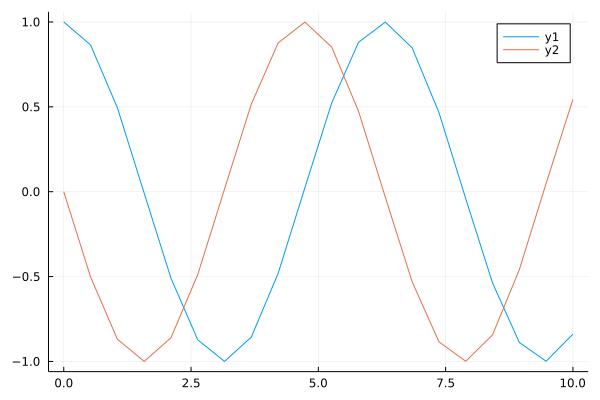

In [14]:
plot(xx, yy)
plot!(xx, yy2)